In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 

In [2]:
# Cell 2: Load Data and Initial Inspection
df = pd.read_csv('../dataset/mental_health_score_prediction.csv')

print("Dataset loaded successfully.")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDataset Description (Numerical features):")
print(df.describe())

# Quick check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check the distribution and range of the target variable
print("\nTarget variable (mental_health_score) description:")
print(df['mental_health_score'].describe())

Dataset loaded successfully.

First 5 rows:
   age  gender  daily_screen_time_hours  social_media_hours  \
0   51       0                      4.8                 4.1   
1   64       1                      3.9                 2.7   
2   41       2                     10.5                 3.0   
3   27       2                      8.8                 3.3   
4   55       1                      5.9                 1.1   

   sleep_duration_hours  sleep_quality  mood_rating  stress_level  \
0                   6.6              6            6            10   
1                   4.5              7            5             6   
2                   7.1              9            5             5   
3                   5.1              9           10             5   
4                   7.4              2            8             7   

   physical_activity_hours_per_week  eats_healthy  caffeine_intake_mg_per_day  \
0                               0.7             1                       125.2   


In [3]:
# Cell 3: Define Features (X) and Target (y)

# Based on your input, excluding 'age' and 'gender'
feature_columns = [
    'daily_screen_time_hours',
    'social_media_hours',
    'sleep_duration_hours',
    'sleep_quality',
    'mood_rating',
    'stress_level',
    'physical_activity_hours_per_week',
    'eats_healthy',
    'caffeine_intake_mg_per_day',
    'gaming_hours', # Using gaming_hours as confirmed
]

target_column = 'mental_health_score'

X = df[feature_columns]
y = df[target_column]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nSelected Features:")
print(feature_columns)

# Check for non-numeric data types
if not X.select_dtypes(include=np.number).columns.tolist() == X.columns.tolist():
    print("\nWarning: Non-numeric features detected! Preprocessing (e.g., one-hot encoding) might be needed.")

Features (X) shape: (2000, 10)
Target (y) shape: (2000,)

Selected Features:
['daily_screen_time_hours', 'social_media_hours', 'sleep_duration_hours', 'sleep_quality', 'mood_rating', 'stress_level', 'physical_activity_hours_per_week', 'eats_healthy', 'caffeine_intake_mg_per_day', 'gaming_hours']


In [4]:
# Cell 4: Split Data into Train, Validation, and Test Sets (70/15/15)

# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Step 1: Split combined data into 85% (train+val) and 15% (test)
X_combined, X_test, y_combined, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42
)

# Step 2: Split the combined data (X_combined, y_combined) into ~82.35% (train) and ~17.65% (val)
# Calculate the new test_size relative to the combined set
relative_val_ratio = val_ratio / (train_ratio + val_ratio)

X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y_combined, test_size=relative_val_ratio, random_state=42 # Use the same random_state
)

print(f"Original data shape: {X.shape}")
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Verify ratios (approximately)
print(f"Train ratio: {len(X_train)/len(X):.2f}")
print(f"Validation ratio: {len(X_val)/len(X):.2f}")
print(f"Test ratio: {len(X_test)/len(X):.2f}")

Original data shape: (2000, 10)
Train data shape: (1400, 10)
Validation data shape: (300, 10)
Test data shape: (300, 10)
Train ratio: 0.70
Validation ratio: 0.15
Test ratio: 0.15


In [5]:
# Cell 5: Define Hyperparameter Search Space for XGBoost

# Define the parameter distribution for RandomizedSearchCV for XGBoost
param_dist_xgb = {
    'n_estimators': randint(100, 1000), # Number of boosting rounds/trees
    'learning_rate': uniform(0.01, 0.3), # Step size shrinkage
    'max_depth': randint(3, 10), # Maximum tree depth
    'subsample': uniform(0.6, 0.4), # Fraction of samples for fitting the trees
    'colsample_bytree': uniform(0.6, 0.4), # Fraction of features for training each tree
    'gamma': uniform(0, 0.5), # Minimum loss reduction required for a split
    'reg_alpha': uniform(0, 1), # L1 regularization
    'reg_lambda': uniform(0, 1) # L2 regularization
}

print("XGBoost Hyperparameter search space defined.")
print(param_dist_xgb)

XGBoost Hyperparameter search space defined.
{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa3ebd7c910>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa3ebd7dbd0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa3ebd7dd50>, 'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa3ebd7c390>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa3ebd7e890>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa3ebd7ed10>, 'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa3ebd7f8d0>, 'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa3ebd91690>}


In [6]:
# Cell 6: Initialize and Run Randomized Search for XGBoost Tuning

# Initialize the base XGBoost model
# Setting objective to 'reg:squarederror' for regression
# n_jobs=-1 for parallel processing
# random_state for reproducibility
xgb_base = xgb.XGBRegressor(objective='reg:squarederror',
                            random_state=42,
                            n_jobs=-1,
                            tree_method='hist') # 'hist' can be faster for larger datasets

# Initialize RandomizedSearchCV for XGBoost
# Searching 50 different combinations
# Using negative MAE as the scoring metric (higher is better for search, so we negate MAE)
# 5-fold cross-validation on the training data
xgb_random_search = RandomizedSearchCV(estimator=xgb_base,
                                       param_distributions=param_dist_xgb,
                                       n_iter=50, # Number of parameter settings that are sampled
                                       scoring='neg_mean_absolute_error',
                                       cv=5, # 5-fold cross-validation on the training set
                                       verbose=2, # Controls the verbosity
                                       random_state=42,
                                       n_jobs=-1) # Use all available cores

print("RandomizedSearchCV for XGBoost initialized. Starting search...")

# Fit RandomizedSearchCV on the training data
xgb_random_search.fit(X_train, y_train)

print("\nXGBoost Randomized search complete.")
print("\nBest parameters found:")
print(xgb_random_search.best_params_)
print("\nBest cross-validation MAE (from training set):")
print(-xgb_random_search.best_score_) # Convert negative MAE back to positive

RandomizedSearchCV for XGBoost initialized. Starting search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.749816047538945, gamma=0.4753571532049581, learning_rate=0.22959818254342154, max_depth=7, n_estimators=120, reg_alpha=0.15601864044243652, reg_lambda=0.15599452033620265, subsample=0.6232334448672797; total time=   2.1s
[CV] END colsample_bytree=0.6727299868828402, gamma=0.09170225492671691, learning_rate=0.1012726728878613, max_depth=8, n_estimators=352, reg_alpha=0.43194501864211576, reg_lambda=0.2912291401980419, subsample=0.8447411578889518; total time=   0.5s
[CV] END colsample_bytree=0.6557975442608167, gamma=0.14607232426760908, learning_rate=0.1199085529881075, max_depth=8, n_estimators=786, reg_alpha=0.6183860093330873, reg_lambda=0.38246199126716274, subsample=0.9932923543227152; total time=   0.4s
[CV] END colsample_bytree=0.6693458614031088, gamma=0.1955303037866204, learning_rate=0.0646708263364187, max_depth=6, n_estimat

In [7]:
# Cell 7: Evaluate Best XGBoost Model on Validation Set

# Get the best model found by RandomizedSearchCV
best_xgb_model = xgb_random_search.best_estimator_

print("Evaluating the best XGBoost model on the validation set...")

# Make predictions on the validation data
y_pred_val = best_xgb_model.predict(X_val)

# Calculate evaluation metrics on the validation set
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print(f"\n--- Model Evaluation on Validation Set (XGBoost after tuning) ---")
print(f"Mean Absolute Error (MAE) on Val: {mae_val:.2f}")
print(f"Root Mean Squared Error (RMSE) on Val: {rmse_val:.2f}")
print(f"R-squared (R2) on Val: {r2_val:.2f}")
print("-----------------------------------------------------------------")

print("\nInterpretation on Validation Set:")
print("This gives an estimate of the tuned XGBoost model's performance on data not seen during training or tuning CV.")

Evaluating the best XGBoost model on the validation set...

--- Model Evaluation on Validation Set (XGBoost after tuning) ---
Mean Absolute Error (MAE) on Val: 14.65
Root Mean Squared Error (RMSE) on Val: 17.21
R-squared (R2) on Val: 0.01
-----------------------------------------------------------------

Interpretation on Validation Set:
This gives an estimate of the tuned XGBoost model's performance on data not seen during training or tuning CV.


In [8]:
# Cell 8: Final Evaluation on Test Set using the Best XGBoost Model

print("Performing final evaluation on the TEST set using the best XGBoost model...")

# Make predictions on the test data using the best model
y_pred_test = best_xgb_model.predict(X_test)

# Calculate evaluation metrics on the test set
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"\n--- FINAL Model Evaluation on TEST Set (XGBoost) ---")
print(f"Mean Absolute Error (MAE) on Test: {mae_test:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test: {rmse_test:.2f}")
print(f"R-squared (R2) on Test: {r2_test:.2f}")
print("----------------------------------------------------")

# Display first few test predictions vs actual for visual check
print("\nFirst 10 Test Predictions vs Actual:")
for i in range(10):
    print(f"Actual: {y_test.iloc[i]:.2f}, Predicted: {y_pred_test[i]:.2f}")

Performing final evaluation on the TEST set using the best XGBoost model...

--- FINAL Model Evaluation on TEST Set (XGBoost) ---
Mean Absolute Error (MAE) on Test: 14.96
Root Mean Squared Error (RMSE) on Test: 17.42
R-squared (R2) on Test: 0.00
----------------------------------------------------

First 10 Test Predictions vs Actual:
Actual: 65.00, Predicted: 51.56
Actual: 62.00, Predicted: 49.53
Actual: 20.00, Predicted: 49.46
Actual: 35.00, Predicted: 49.43
Actual: 75.00, Predicted: 50.48
Actual: 23.00, Predicted: 50.15
Actual: 51.00, Predicted: 48.26
Actual: 60.00, Predicted: 50.99
Actual: 75.00, Predicted: 51.50
Actual: 21.00, Predicted: 49.41


Calculating Feature Importances for the Best XGBoost Model...

--- XGBoost Feature Importances (Sorted by Gain) ---
stress_level                        0.111040
caffeine_intake_mg_per_day          0.111031
physical_activity_hours_per_week    0.107640
sleep_quality                       0.103751
eats_healthy                        0.101718
gaming_hours                        0.099677
mood_rating                         0.097800
social_media_hours                  0.091842
sleep_duration_hours                0.090961
daily_screen_time_hours             0.084539
dtype: float32
---------------------------------------------------


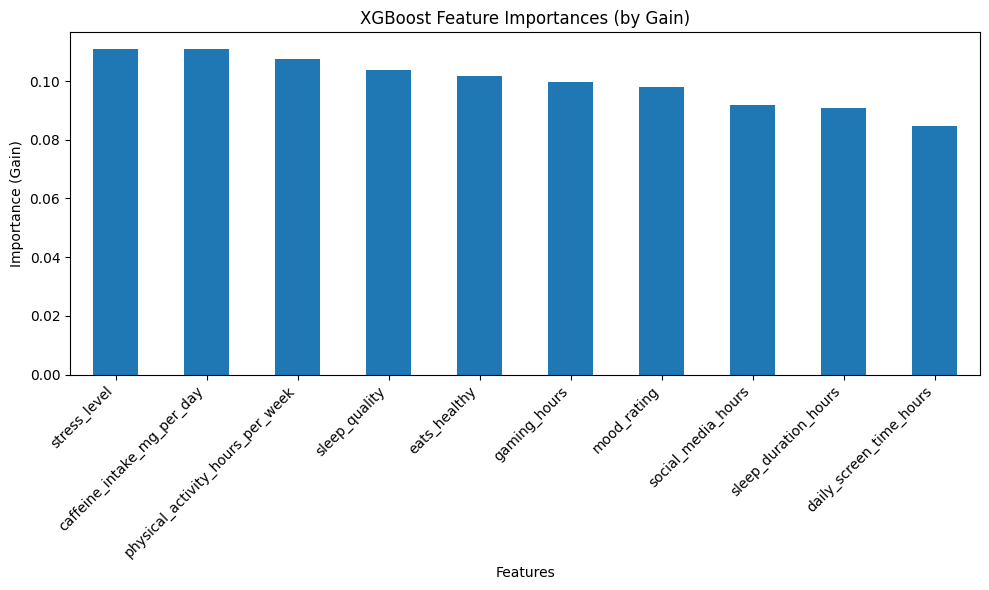


Interpretation of Feature Importance:
For XGBoost, 'Gain' is the average improvement in accuracy by splits using this feature.
Higher gain means the feature was more important for making accurate predictions across the boosted trees.


In [9]:
# Cell 9: Calculate and Display XGBoost Feature Importance

print("Calculating Feature Importances for the Best XGBoost Model...")

# Access the feature importances from the best XGBoost model
# Default importance type is 'gain'
importances_xgb = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a pandas Series for easier handling and sorting
feature_importance_series_xgb = pd.Series(importances_xgb, index=feature_names)

# Sort the features by importance in descending order
sorted_feature_importance_xgb = feature_importance_series_xgb.sort_values(ascending=False)

print("\n--- XGBoost Feature Importances (Sorted by Gain) ---")
print(sorted_feature_importance_xgb)
print("---------------------------------------------------")

# Optional: Plot the feature importances for visualization
plt.figure(figsize=(10, 6))
sorted_feature_importance_xgb.plot(kind='bar')
plt.title('XGBoost Feature Importances (by Gain)')
plt.ylabel('Importance (Gain)')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nInterpretation of Feature Importance:")
print("For XGBoost, 'Gain' is the average improvement in accuracy by splits using this feature.")
print("Higher gain means the feature was more important for making accurate predictions across the boosted trees.")

In [10]:
# Cell 10: Interpretation of XGBoost Results and Next Steps (Discussion)

print("\n--- Interpretation and Next Steps ---")
print("Evaluation on the TEST set using the tuned XGBoost model:")
print(f"Final MAE: {mae_test:.2f}")
print(f"Final RMSE: {rmse_test:.2f}")
print(f"Final R-squared (R2): {r2_test:.2f}")

print("\nAnalysis:")
# Compare XGBoost R2 to Random Forest R2 (-0.02)
if r2_test > -0.01: # Check if R2 is positive or very close to zero
    print("The R-squared value is positive (or very close to zero), which is an improvement over the negative R2 from the Random Forest model.")
    print("This suggests XGBoost was able to capture a *small* amount of the variance in the mental health score.")
else:
     print("The R-squared value is still negative (or very close to zero), similar to the Random Forest model.")
     print("This further reinforces that the current features have little to no predictive power for the mental health score in this dataset.")

print(f"The MAE ({mae_test:.2f}) and RMSE ({rmse_test:.2f}) indicate the typical prediction error is still quite large relative to the target score range (20-80).")

print("\nFeature Importance from XGBoost:")
print("The feature importance plot shows which features were most useful for the XGBoost model.")
print("Compare these importances to the correlations and RF importances. Do they align? (Note: Importance doesn't guarantee prediction power if the overall R2 is low).")

print("\nOverall Conclusion based on Data Exploration and Models:")
print("Both Random Forest and XGBoost, even after tuning, achieved very low or negative R-squared values on the test set.")
print("This, combined with the near-zero correlations and lack of clear patterns in the data exploration, strongly indicates that the current set of features **do not adequately predict the mental health score** in this dataset.")
print("Trying other standard ML models is unlikely to yield significantly better results if the fundamental signal is missing.")

print("\nRecommended Next Steps:")
print("1.  **Revisit Data & Problem Definition (Highest Priority):** This is the most likely area for improvement.")
print("    -  Confirm the relevance of the chosen features to this specific mental health score.")
print("    -  Identify and potentially acquire **missing features** that are known drivers of mental health (e.g., psychological assessments, social factors, health conditions, life events).")
print("    -  Evaluate the **data quality** and collection process.")
print("    -  Consider if the prediction task should be redefined (e.g., predicting changes, predicting categories, or focusing on a different target).")
print("2.  **Advanced Data Analysis:** If new features are acquired, repeat the data exploration steps.")
print("3.  **Domain Expertise:** Consult with mental health professionals or domain experts to understand what factors *should* be predictive and how they might interact.")
print("4.  **Alternative Modeling Approaches (Lower Priority without new data):** Only consider this if Step 1 reveals new data or insights.")
print("    -  Deep Learning models *could* potentially find very complex patterns, but require significantly more data and computational resources, and are unlikely to succeed if basic relationships are absent.")


--- Interpretation and Next Steps ---
Evaluation on the TEST set using the tuned XGBoost model:
Final MAE: 14.96
Final RMSE: 17.42
Final R-squared (R2): 0.00

Analysis:
The R-squared value is positive (or very close to zero), which is an improvement over the negative R2 from the Random Forest model.
This suggests XGBoost was able to capture a *small* amount of the variance in the mental health score.
The MAE (14.96) and RMSE (17.42) indicate the typical prediction error is still quite large relative to the target score range (20-80).

Feature Importance from XGBoost:
The feature importance plot shows which features were most useful for the XGBoost model.
Compare these importances to the correlations and RF importances. Do they align? (Note: Importance doesn't guarantee prediction power if the overall R2 is low).

Overall Conclusion based on Data Exploration and Models:
Both Random Forest and XGBoost, even after tuning, achieved very low or negative R-squared values on the test set.
Th